In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 2s (3,898 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
plt.rc('font', family='NanumBarunGothic')
style.use('ggplot')

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/전력예측/test.csv', encoding='cp949')
train = pd.read_csv('/content/drive/MyDrive/전력예측/train.csv',encoding='cp949')

### 1. train, test 셋 데이터 형태 확인

In [ ]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(test.shape)
print(test['date_time'].max())
print(test['date_time'].min())

(10080, 9)
2020-08-31 23
2020-08-25 00


In [ ]:
print(test.info())
print('-'*50)
print(test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB
None
--------------------------------------------------
num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


#### (1) test셋
##### - 결측치가 많다
##### - 약 1만개의 행을 가지고 있음
##### - 2020년 8월25일부터 8월 31일 23시까지의 전력사용량을 예측해야 함

#### 결측치 처리 문제
##### - 기온, 풍속, 습도, 강수량, 일조 등의 연속형 변수는 동일날짜, 동일시간, 동일 건물 등을 이용해 채울 수 있을 것 같다. 만약, 건물들이 같은 지역에 있다면 더 쉬울듯하다
##### - 비전기냉방설비운영, 태양광보유: 범주형 변수로 0 or 1로 나타나 있음. 건물번호에 맞게 채워주면 된다 -> 문제, 만약 해당 일자부터 냉방설비운영이 0에서 1로 바뀔 수가 있는지, 태양광보유 역시 같은 문제

In [ ]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [ ]:
print(train.shape)
print(train['date_time'].max())
print(train['date_time'].min())

(122400, 10)
2020-08-24 23
2020-06-01 00


In [ ]:
print(train.info())
print('-'*50)
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB
None
--------------------------------------------------
num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64


### 2. 기초 전처리
##### -요일변수, 주말여부변수, 연도, 월, 시간, 일 변수 생성

In [ ]:
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else:
        return 0

In [ ]:
def coding(df):
    df.rename(columns={'num':'건물번호',
                       '전력사용량(kWh)':'전력사용량',
                       '기온(°C)':'기온',
                       '풍속(m/s)':'풍속',
                       '습도(%)':'습도',
                       '강수량(mm, 6시간)':'강수량',
                       '일조(hr, 3시간)':'일조',
                       '강수량(mm)':'강수량',
                       '일조(hr)':'일조'}, inplace=True)

    df['date_time'] = pd.to_datetime(df['date_time'])

    # 연도, 월, 일, 시간 column 생성
    df['연도'] = df['date_time'].dt.year
    df['월'] = df['date_time'].dt.month
    df['일'] = df['date_time'].dt.day
    df['시간'] = df['date_time'].dt.hour

    df['요일'] = df['date_time'].apply(weekday)
    df['주말'] = df['date_time'].apply(weekend)

    return(df)

In [ ]:
train = coding(df=train)
test = coding(df=test)

## 3. test셋 결측치 보간

In [ ]:
test.head(10)

,건물번호,date_time,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,연도,월,일,시간,요일,주말
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN,2020,8,25,0,화,0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,25,1,화,0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,25,2,화,0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN,2020,8,25,3,화,0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,25,4,화,0
5,1,2020-08-25 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,25,5,화,0
6,1,2020-08-25 06:00:00,26.1,1.3,83.0,0.0,0.0,NaN,NaN,2020,8,25,6,화,0
7,1,2020-08-25 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,25,7,화,0
8,1,2020-08-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,25,8,화,0
9,1,2020-08-25 09:00:00,28.8,1.2,77.0,NaN,1.1,NaN,NaN,2020,8,25,9,화,0


In [ ]:
test.shape

(10080, 15)

In [ ]:
test.isnull().sum()

건물번호            0
date_time       0
기온              0
풍속              0
습도              0
강수량             0
일조              0
비전기냉방설비운영    7784
태양광보유        8456
연도              0
월               0
일               0
시간              0
요일              0
주말              0
dtype: int64

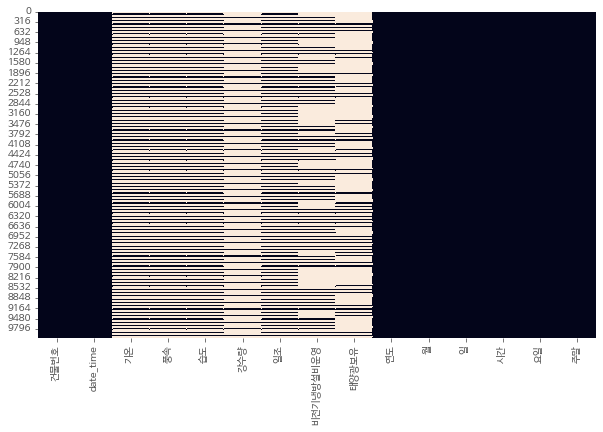

In [ ]:
from matplotlib import rc, style, font_manager
plt.rc('font', family='NanumBarunGothic')

plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(),cbar=False)
plt.show();

##### 기온, 풍속, 습도, 일조 칼럼은 2칸 간격으로 결측치가 존재함
##### 강수량 칼럼은 6칸 간격으로 결측치가 존재함
##### 범주형 변수는 등간격이 아님

##### -기온, 풍속, 습도, 일조, 강수량 칼럼은 각 간격에 맞게 앞의 값으로 보간
##### -비전기냉낭방설비운영, 태양광보유 변수는 건물번호에 맞게 보간(?) -> 불확실하니까 예측 시에는 일단 제외

In [ ]:
#pad로 지정하여 앞 행의 값으로 보간하도록 설정

test['기온'] = test['기온'].interpolate(method='pad')
test['풍속'] = test['풍속'].interpolate(method='pad')
test['습도'] = test['습도'].interpolate(method='pad')
test['일조'] = test['일조'].interpolate(method='pad')
test['강수량'] = test['강수량'].interpolate(method='pad')

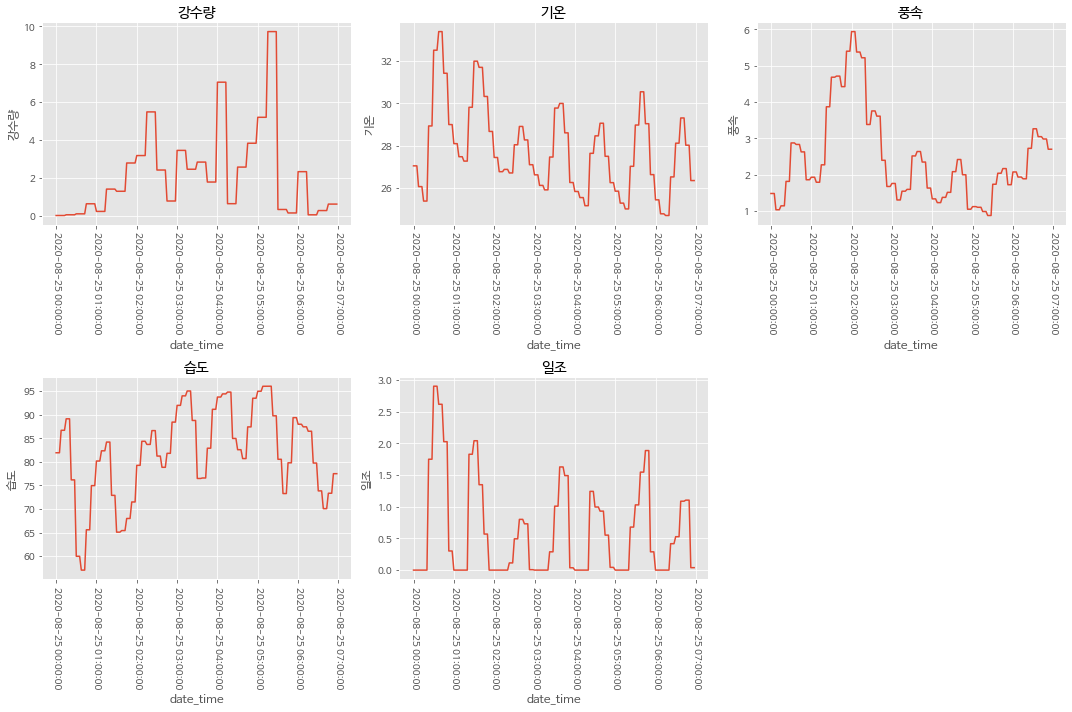

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

sns.lineplot(x='date_time', y='강수량', ci=None, data=test, ax=axes[0, 0])
axes[0, 0].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[0, 0].set_title('강수량')

sns.lineplot(x='date_time', y='기온', ci=None, data=test, ax=axes[0, 1])
axes[0, 1].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[0, 1].set_title('기온')

sns.lineplot(x='date_time', y='풍속', ci=None, data=test, ax=axes[0, 2])
axes[0, 2].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[0, 2].set_title('풍속')

sns.lineplot(x='date_time', y='습도', ci=None, data=test, ax=axes[1, 0])
axes[1, 0].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[1, 0].set_title('습도')

sns.lineplot(x='date_time', y='일조', ci=None, data=test, ax=axes[1, 1])
axes[1, 1].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[1, 1].set_title('일조')

# 예시로 마지막 subplot은 비워두었습니다
axes[1, 2].axis('off')

plt.tight_layout()
plt.show();

##### -범주형 변수 결측치 처리
##### -건물번호별로 변화양상이 없는 것을 확인 -> 건물번호에 맞는 값 보간

In [ ]:
train[['건물번호', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']

for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['건물번호'][i]]
    test.loc[i, '태양광보유']=hot[test['건물번호'][i]]

## 4. 예측 모델링

##### -다중선형회귀, 릿지회귀, 라쏘회귀 이용

##### -독립변수: 건물번호, 시간, 요일, 주말(이하 범주형), 기온, 풍속, 습도, 강수량, 일조 (이하 연속형)
##### -종속변수: 전력사용량

In [ ]:
train.head()

,건물번호,date_time,전력사용량,기온,풍속,습도,강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,연도,월,일,시간,요일,주말
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0,월,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1,월,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2,월,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3,월,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4,월,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   건물번호       122400 non-null  int64         
 1   date_time  122400 non-null  datetime64[ns]
 2   전력사용량      122400 non-null  float64       
 3   기온         122400 non-null  float64       
 4   풍속         122400 non-null  float64       
 5   습도         122400 non-null  float64       
 6   강수량(mm)    122400 non-null  float64       
 7   일조(hr)     122400 non-null  float64       
 8   비전기냉방설비운영  122400 non-null  float64       
 9   태양광보유      122400 non-null  float64       
 10  연도         122400 non-null  int64         
 11  월          122400 non-null  int64         
 12  일          122400 non-null  int64         
 13  시간         122400 non-null  int64         
 14  요일         122400 non-null  object        
 15  주말         122400 non-null  int64         
dtypes: datetime64[ns](1)

#### (1) 변수간 상관 확인
##### - 유의미한 관계 확인 x -> 아마 건물별로 다를 것으로 보임

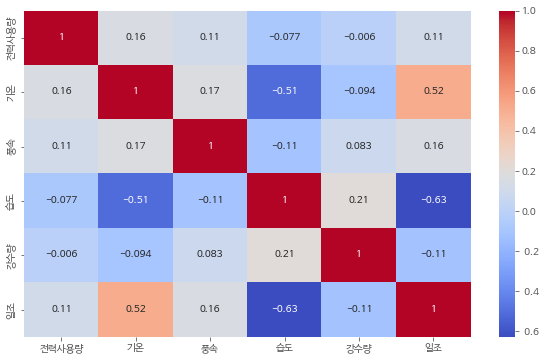

In [ ]:
train1 = train.iloc[:,2:8]
plt.figure(figsize=(10,6))
sns.heatmap(train1.corr(), cmap='coolwarm', annot=True)
plt.show();

#### (2) 건물별 특징 파악 및 군집화

In [ ]:
train['건물번호'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

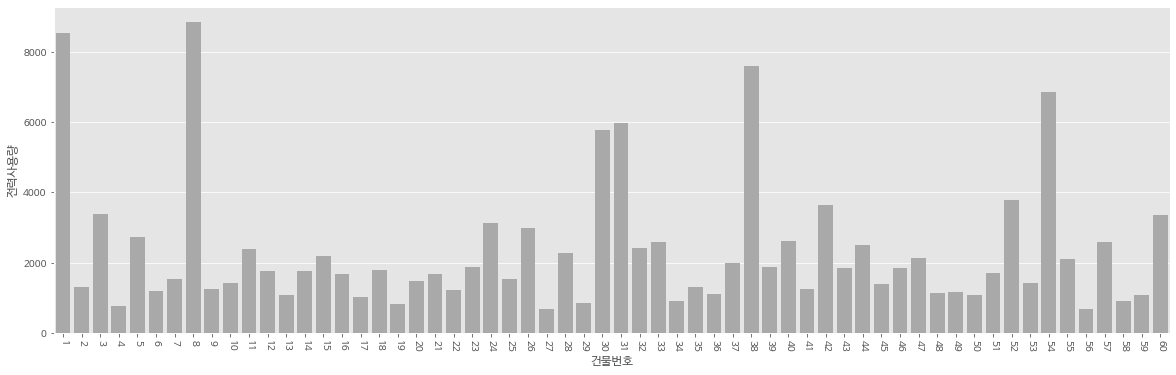

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(x='건물번호',y='전력사용량',data=train,ci=None,color='darkgrey')
plt.xticks(rotation=-90)
plt.show();

In [ ]:
train

,건물번호,date_time,전력사용량,기온,풍속,습도,강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,연도,월,일,시간,요일,주말,전력사용량log
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0,월,0,9.009454
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1,월,0,9.004133
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2,월,0,9.000622
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3,월,0,8.993404
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4,월,0,8.992759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020,8,24,19,월,0,8.322484
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020,8,24,20,월,0,8.288207
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020,8,24,21,월,0,8.181219
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020,8,24,22,월,0,8.101734


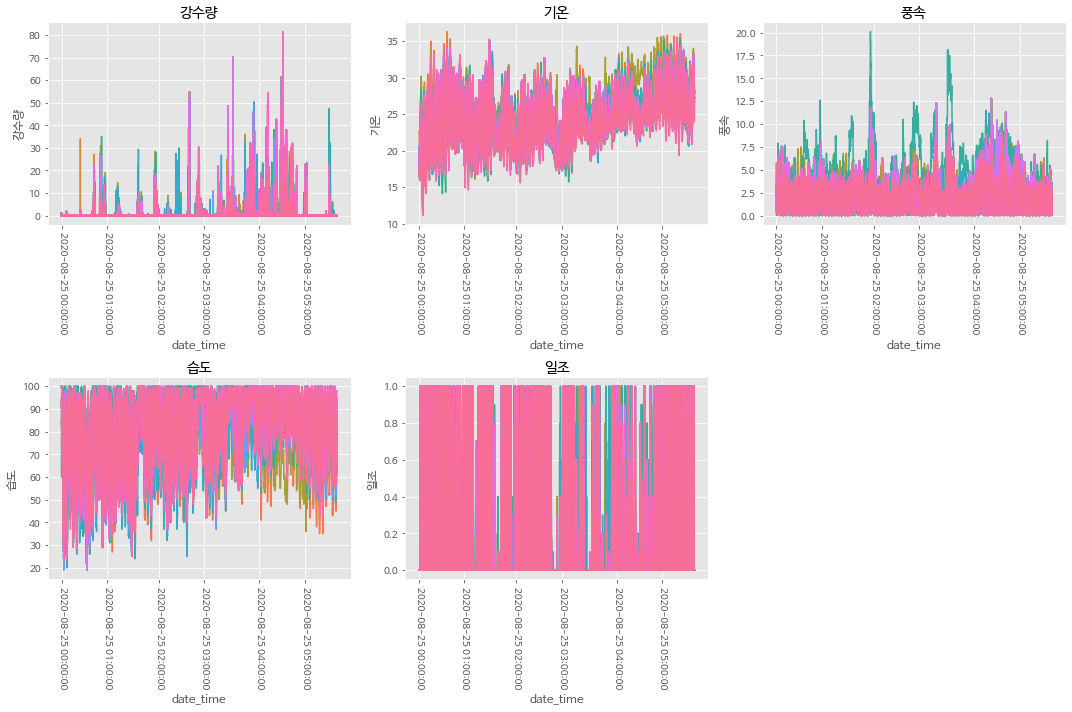

In [ ]:
train = train.astype({'건물번호':'str'})

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

sns.lineplot(x='date_time', y='강수량', ci=None, data=train, hue='건물번호', ax=axes[0, 0])
axes[0, 0].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[0, 0].set_title('강수량')
axes[0, 0].legend([],[], frameon=False)

sns.lineplot(x='date_time', y='기온', ci=None, data=train, hue='건물번호',ax=axes[0, 1])
axes[0, 1].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[0, 1].set_title('기온')
axes[0, 1].legend([],[], frameon=False)

sns.lineplot(x='date_time', y='풍속', ci=None, data=train, hue='건물번호',ax=axes[0, 2])
axes[0, 2].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[0, 2].set_title('풍속')
axes[0, 2].legend([],[], frameon=False)

sns.lineplot(x='date_time', y='습도', ci=None, data=train, hue='건물번호',ax=axes[1, 0])
axes[1, 0].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[1, 0].set_title('습도')
axes[1, 0].legend([],[], frameon=False)

sns.lineplot(x='date_time', y='일조', ci=None, data=train, hue='건물번호',ax=axes[1, 1])
axes[1, 1].set_xticklabels(labels=test['date_time'], rotation=-90)
axes[1, 1].set_title('일조')
axes[1, 1].legend([],[], frameon=False)

# 예시로 마지막 subplot은 비워두었습니다
axes[1, 2].axis('off')

plt.tight_layout()
plt.show();

##### 건물번호간, 강수량, 기온, 풍속, 습도, 일조 간에 차이가 있는지 확인 -> 일조를 제외하면 차이가 있어보인다
##### 따라서 60개의 건물을 위 5개의 변수를 이용해 군집화하여 건물번호 대신 군집을 독립변수로 적용해보자

In [ ]:
train = train.astype({'건물번호':'float'})

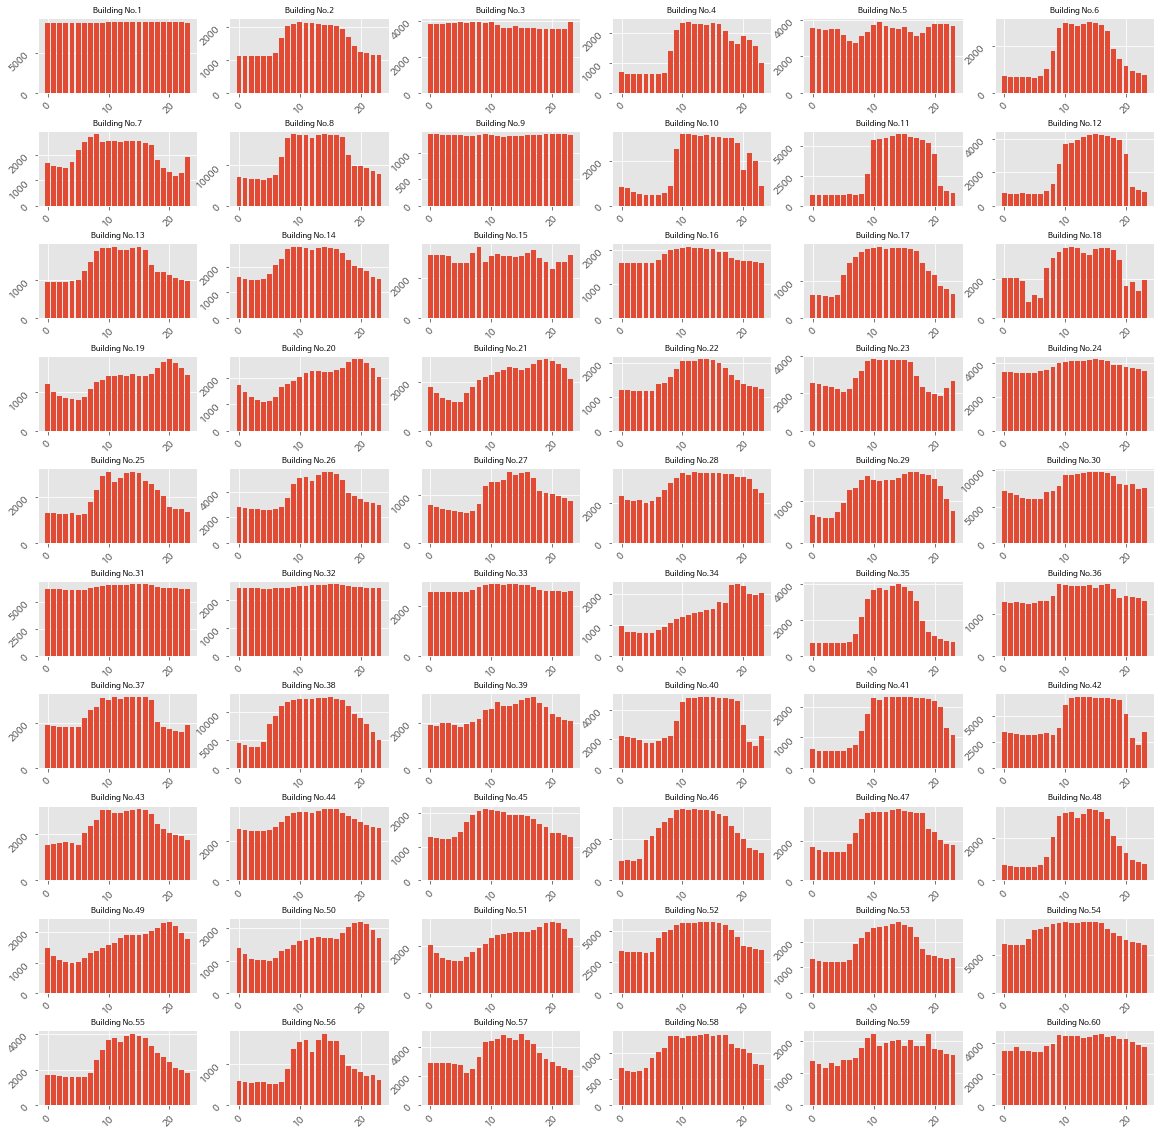

In [ ]:
# 건물번호를 그룹화한 뒤 subplot으로 그래프 그리기
fig, axes = plt.subplots(10, 6, figsize=(20, 20))
axes = axes.ravel()

for i in range(60):
    temp = train[train['건물번호']==i+1]
    axes[i].bar(temp['시간'], temp['전력사용량'])
    axes[i].set_title('Building No.{}'.format(i+1),fontsize=8)
    axes[i].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=0.5)
plt.show()

##### -건물별로 시간대에 따른 전력사용량에 차이가 존재하더라 -> 그래서 전력사용량과 시간대, 건물번호를 변수로 하여 군집화가 필요할 것으로 보임

In [ ]:
train.columns

Index(['건물번호', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조',
       '비전기냉방설비운영', '태양광보유', '연도', '월', '일', '시간', '요일', '주말', '전력사용량log'],
      dtype='object')

In [ ]:
train.groupby(['건물번호','시간','전력사용량']).size().reset_index()

,건물번호,시간,전력사용량,0
0,1.0,0,7920.504,1
1,1.0,0,8114.904,1
2,1.0,0,8179.056,1
3,1.0,0,8254.872,1
4,1.0,0,8439.552,1
...,...,...,...,...
118670,60.0,23,3403.728,1
118671,60.0,23,3420.144,1
118672,60.0,23,3499.200,1
118673,60.0,23,3549.312,1


##### 건물번호를 기준으로 전력사용량, 기온, 풍속, 습도, 강수량, 일조의 평균값을 데이터프레임으로 구성 후, 클러스터링 진행

In [ ]:
build = train.groupby('건물번호')['전력사용량','기온','풍속','습도','강수량','일조'].mean()

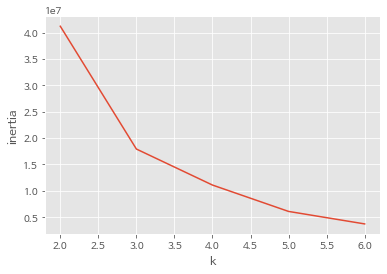

In [ ]:
# 엘보우 방법을 통한 클러스터 개수 확인
inertia = []
for k in range(2, 7) :
  km = KMeans(n_clusters = k)
  km.fit(build)
  inertia.append(km.inertia_)
plt.plot(range(2,7), inertia)
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

In [ ]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(build)
KMeans(n_clusters=3, random_state=0)

KMeans(n_clusters=3, random_state=0)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(build)

build['pca_x'] = pca_transformed[:,0]
build['pca_y'] = pca_transformed[:,1]
build.head(3)

,전력사용량,기온,풍속,습도,강수량,일조,pca_x,pca_y
건물번호,,,,,,,,
1,8543.273488,24.608578,2.34598,75.971569,0.493873,0.184608,6218.442446,-4.470095
10,1427.164069,23.623333,3.19799,81.113725,0.720098,0.238725,-897.666718,1.028275
11,2391.372635,23.623333,3.19799,81.113725,0.720098,0.238725,66.541847,0.987339


In [ ]:
build['클러스터'] = kmeans.labels_

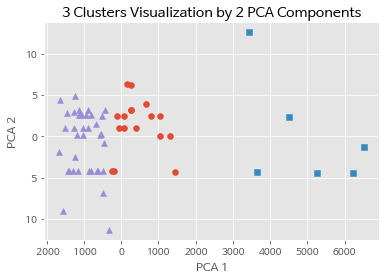

In [ ]:
# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = build[build['클러스터']==0].index
marker1_ind = build[build['클러스터']==1].index
marker2_ind = build[build['클러스터']==2].index
marker3_ind = build[build['클러스터']==3].index
marker4_ind = build[build['클러스터']==4].index


# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 마커 표시
plt.scatter(x=build.loc[marker0_ind, 'pca_x'], y=build.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=build.loc[marker1_ind, 'pca_x'], y=build.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=build.loc[marker2_ind, 'pca_x'], y=build.loc[marker2_ind, 'pca_y'], marker='^')
plt.scatter(x=build.loc[marker3_ind, 'pca_x'], y=build.loc[marker3_ind, 'pca_y'], marker='4')
plt.scatter(x=build.loc[marker4_ind, 'pca_x'], y=build.loc[marker4_ind, 'pca_y'], marker='+')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

In [ ]:
build = build.reset_index(drop=False)
build.head()

,건물번호,전력사용량,기온,풍속,습도,강수량,일조,pca_x,pca_y,클러스터
0,1,8543.273488,24.608578,2.345980,75.971569,0.493873,0.184608,6218.442446,-4.470095,1
1,10,1427.164069,23.623333,3.197990,81.113725,0.720098,0.238725,-897.666718,1.028275,2
2,11,2391.372635,23.623333,3.197990,81.113725,0.720098,0.238725,66.541847,0.987339,0
3,12,1748.853338,23.323186,2.781814,80.238824,0.395833,0.246765,-575.977509,0.145130,2
4,13,1089.115200,24.309657,1.264265,77.677941,0.519167,0.206569,-1235.715809,-2.454600,2


In [ ]:
cluster = build.drop(columns=['전력사용량','기온','풍속','습도','강수량','일조','pca_x','pca_y'], axis=1)

In [ ]:
train = pd.merge(train,cluster, how='inner',on='건물번호')

#### (3) 종속변수 분포도 확인
##### 높은 첨도 -> 로그 변환

왜도: 2.57
첨도: 8.998


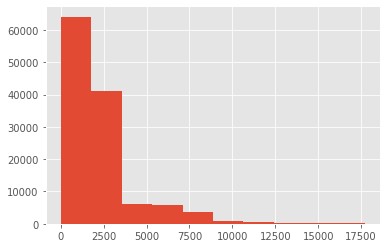

In [ ]:
from scipy import stats

print('왜도:',round(stats.skew(train['전력사용량']),3))
print('첨도:',round(stats.kurtosis(train['전력사용량']),3))

plt.hist(train['전력사용량'])
plt.show();

In [ ]:
#로그변환
train['전력사용량log'] = np.log1p(train['전력사용량'])

왜도: 0.181
첨도: 0.279


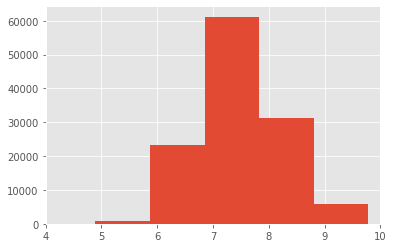

In [ ]:
print('왜도:',round(stats.skew(train['전력사용량log']),3))
print('첨도:',round(stats.kurtosis(train['전력사용량log']),3))

plt.hist(train['전력사용량log'])
plt.xlim([4,10])
plt.show();

### (4) 변수 인코딩

In [ ]:
train.columns

Index(['건물번호', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조',
       '비전기냉방설비운영', '태양광보유', '연도', '월', '일', '시간', '요일', '주말'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = train['전력사용량log']
X_features = train.drop(['건물번호','전력사용량','date_time','비전기냉방설비운영','태양광보유','연도','월','일','전력사용량log'],axis=1,inplace=False)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# One-hot encoding
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(X_features[['시간', '요일', '주말']])
df_one_hot = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names(['시간', '요일', '주말']))
X_features = pd.concat([X_features.drop(['시간', '요일', '주말'], axis=1), df_one_hot], axis=1)

In [ ]:
train.head()

,건물번호,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,연도,월,일,시간,요일,주말,전력사용량log
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0,월,0,9.009454
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1,월,0,9.004133
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2,월,0,9.000622
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3,월,0,8.993404
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4,월,0,8.992759


In [ ]:
X_features

,기온,풍속,습도,강수량,일조,시간_0,시간_1,시간_2,시간_3,시간_4,...,시간_23,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,주말_0,주말_1
0,17.6,2.5,92.0,0.8,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,17.7,2.9,91.0,0.3,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,17.1,3.2,91.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,17.0,3.3,92.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,27.8,2.3,68.0,0.0,0.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
122396,27.3,1.2,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
122397,27.3,1.8,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
122398,27.1,1.8,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### (5) train_test_스플릿

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

### (6) 표준화 변환

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train)
test_features = scaler.transform(X_test)

### (7) 평가지표 생성

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### (8) 회귀 적용

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 0.082, RMSE: 0.692, MAE: 0.544


In [ ]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= pred
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=10)

       real_count  predicted_count      diff
23602    0.000000         7.617361  7.617361
11496    4.936199         7.350725  2.414526
21923    5.241324         7.641300  2.399977
23150    5.152922         7.298998  2.146076
12929    9.047384         6.915110  2.132274
15729    9.686699         7.600660  2.086039
9607     9.040803         6.967436  2.073367
1883     9.061019         6.990519  2.070500
10393    9.045322         6.982559  2.062763
23245    5.429653         7.492369  2.062716


### (9) 보완해야 할 점
##### - 체감온도, 불쾌지수 등 필요한 변수를 추가해보자
##### 불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32
##### 체감온도=13.12+0.6215×T-11.37V0.16+0.3965V0.16×T (v는 풍속, T는 온도)

In [ ]:
train['체감온도'] = 13.12 + 0.6215*train['기온'] - 11.37*train['풍속']**0.16 + 0.3965*train['풍속']**0.16*train['기온']
train['불쾌지수'] = 1.8*train['기온'] - 0.55*(1-train['습도'])*(1.8*train['기온']-26) + 32

test['체감온도'] = 13.12 + 0.6215*test['기온'] - 11.37*test['풍속']**0.16 + 0.3965*test['풍속']**0.16*test['기온']
test['불쾌지수'] = 1.8*test['기온'] - 0.55*(1-test['습도'])*(1.8*test['기온']-26) + 32